In [17]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import scipy as sp
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load
from analysis.offsets import offsets

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/gmms/")

%matplotlib inline

## look at GMM covariance task/null space projections

In [3]:
subjects = analysis.load_subjects()

In [4]:
import pandas as pd
trajectory_df = pd.read_pickle("../trajectory_dataframe.pkl")
mean_rewards = 1 / trajectory_df.groupby(level=['subject']).mean()["reward"]

In [5]:
subject_idx = 7

In [7]:
# test subspace projection
decoder = subjects[subject_idx].decoder[-2:,:]
task, null = analysis.compute_subspaces(decoder)
print(task.shape, null.shape)

(2, 64) (62, 64)


In [8]:
def stacked_subspace_projection(C,d):
    t, n = analysis.compute_subspaces(d)
    s = np.row_stack([t,n])
    return analysis.subspace_projection(C, s)

In [9]:
models = model.load_trial_models(subject_idx)

/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
# project each component of each model
# model, component, projection vec
projections = np.zeros(shape=(5,12,64))
markers = [".","*","o","v","s"]
for i, model in enumerate(models):
    for k, cov in enumerate(model.covariances_):
        projections[i,k,:] = stacked_subspace_projection(cov,decoder)

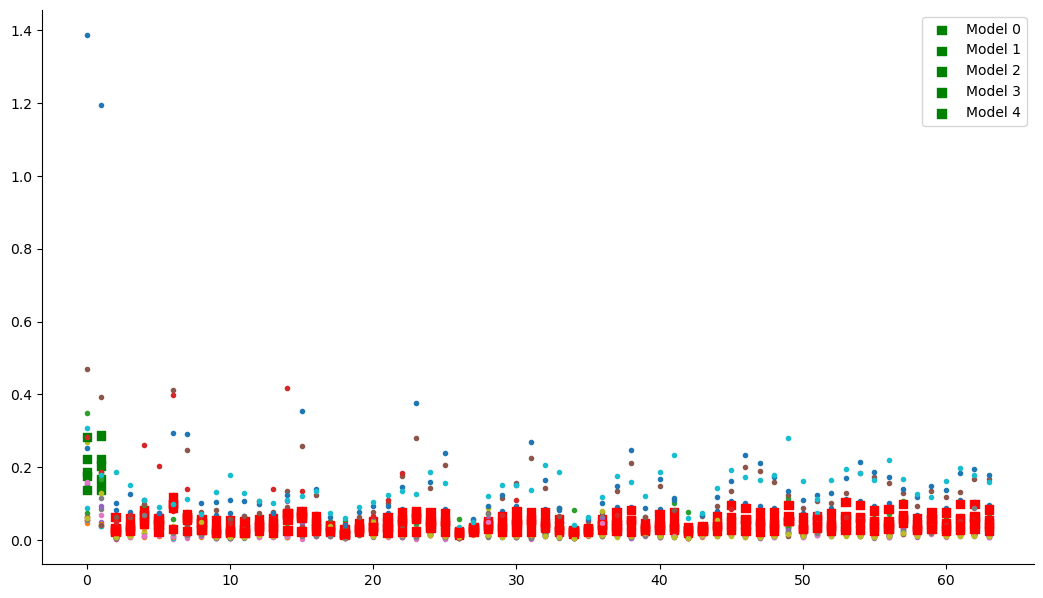

In [11]:
# plot the projections and color the mean for each model
for model_idx in range(5):
    for cpt_idx in range(4):
        p = projections[model_idx, cpt_idx]
        plt.scatter(np.arange(p.shape[0]), p, marker=".")
    plt.scatter(np.arange(p.shape[0]), np.mean(projections, axis=1)[model_idx], marker=markers[i], c=["g","g"] + ["r" for _ in range(62)], label=f"Model {model_idx}")
plt.legend()

# project models onto task+null space -- movement, calibration, trials

In [47]:
mean_projections = np.zeros(shape=(46,7,12,3))
markers = [".","*","o","v","s"]
for subject_idx in range(46):
    decoder = subjects[subject_idx].decoder[-2:,:]
    models = model.load_log_movement_models(subject_idx) + model.load_log_calibration_models(subject_idx) + model.load_log_trial_models(subject_idx)
    task, null = analysis.compute_subspaces(decoder)
    for i, m in enumerate(models):
        for k, cov in enumerate(m.covariances_):
            mean_projections[subject_idx,i,k,0] = analysis.mean_quadratic_form(cov,task)[0] # *models[i].weights_[k]
            mean_projections[subject_idx,i,k,1] = analysis.mean_quadratic_form(cov,null)[0] # *models[i].weights_[k]            
            mean_projections[subject_idx,i,k,2] = mean_projections[subject_idx,i,k,0] / mean_projections[subject_idx,i,k,1]

/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## task/null ratio of models

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/nullspace_ratios_models.pdf
Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/nullspace_pvalues_models.pdf


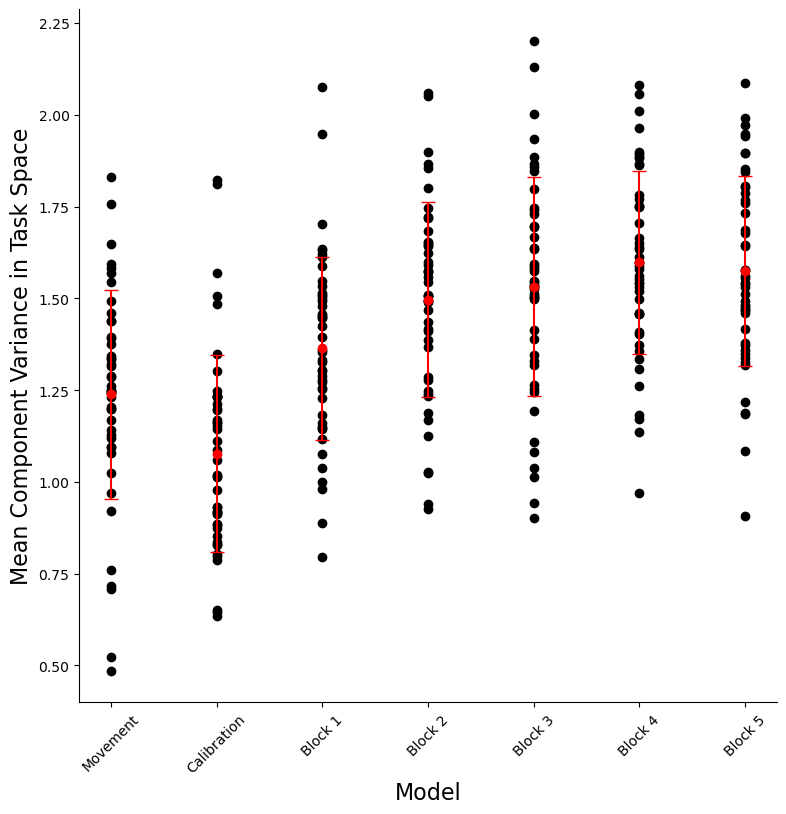

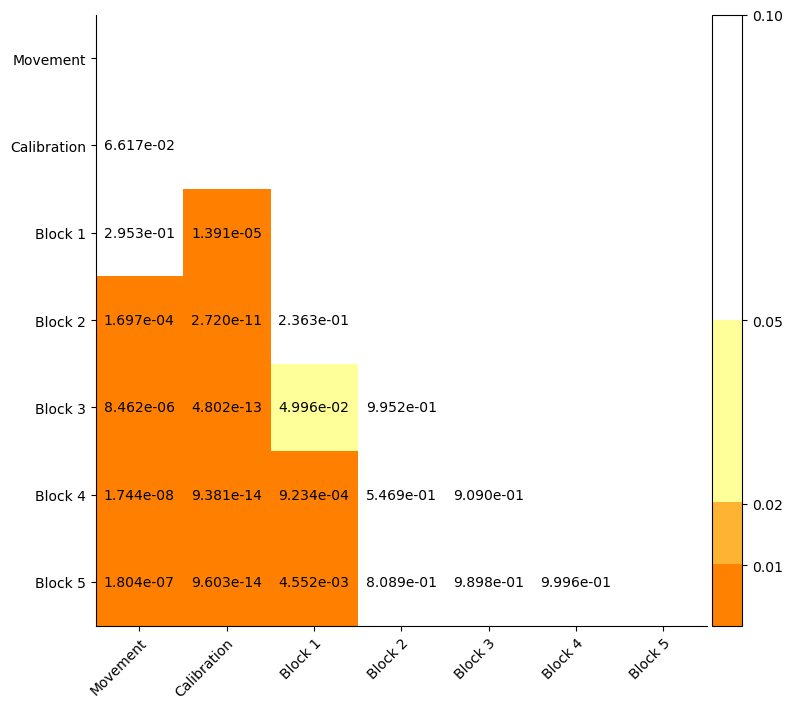

In [59]:
nullspace_ratio_fig = plt.figure(figsize=(9,9))
n_models = mean_projections.shape[1]
xlabels = ["Movement", "Calibration", *[f"Block {i+1}" for i in range(n_models-2)]]

for s in range(46):
    for i in range(n_models):
        plt.plot(i, np.log(np.mean(mean_projections[s,i,:,2])),'ko')

subject_means = np.log(np.mean(mean_projections[:,:,:,2],axis=(2)))

plt.errorbar(x=list(range(n_models)),y=np.mean(subject_means,axis=0),yerr=np.std(subject_means,axis=0),marker="o",color='r',capsize=5,linestyle="none")
plt.xticks(range(n_models),xlabels,rotation=45)
plt.xlabel("Model")
plt.ylabel("Mean Component Variance in Task Space")

from scipy.stats import tukey_hsd
result = tukey_hsd(*(np.array(subject_means.T)))
nullspace_pvalue_fig, _ = plot.annotated_heatmap(result.pvalue,xlabels,xlabels)

plot.save_figure(nullspace_ratio_fig, "nullspace_ratios_models", image_path)
plot.save_figure(nullspace_pvalue_fig, "nullspace_pvalues_models", image_path)